In [1]:
# process.py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

def get_data():
    df = pd.read_csv('ecommerce_data.csv')

    # just in case you're curious what's in it
    # df.head()

    # easier to work with numpy array
    data = df.as_matrix()

    X = data[:,:-1]
    Y = data[:,-1]

    # normalize columns 1 and 2
    X[:,1] = (X[:,1] - X[:,1].mean()) / X[:,1].std()
    X[:,2] = (X[:,2] - X[:,2].mean()) / X[:,2].std()

    # create a new matrix X2 with the correct number of columns
    N, D = X.shape
    X2 = np.zeros((N, D+3))
    X2[:,0:(D-1)] = X[:,0:(D-1)] # non-categorical

    # one-hot
    for n in range(N):
        t = int(X[n,D-1])
        X2[n,t+D-1] = 1

    # method 2
    # Z = np.zeros((N, 4))
    # Z[np.arange(N), X[:,D-1].astype(np.int32)] = 1
    # # assign: X2[:,-4:] = Z
    # assert(np.abs(X2[:,-4:] - Z).sum() < 10e-10)

    return X2, Y



def get_binary_data():
    X, Y = get_data()
    X2 = X[Y <= 1]
    Y2 = Y[Y <= 1]
    return X2, Y2

In [2]:
# ann_predict.py

X, Y = get_data()
M = 5
D = X.shape[1]
K = len(set(Y))
W1 = np.random.randn(D, M)
b1 = np.zeros(M)
W2 = np.random.randn(M, K)
b2 = np.zeros(K)

def softmax(A):
    expA = np.exp(A)
    return expA / expA.sum(axis=1, keepdims=True)

def forward(X, W1, b1, W2, b2):
    Z = np.tanh(X.dot(W1) + b1)
    return softmax(Z.dot(W2) + b2)

P_Y_given_X = forward(X, W1, b1, W2, b2)
predictions = np.argmax(P_Y_given_X, axis=1)

def classification_rate(Y, P):
    return np.mean(Y == P)

print("Score:", classification_rate(Y, predictions))

# Next have to figure out how to train the weights to improve accuracy

Score: 0.278


In [3]:
X = np.array([[1,2]])
W1 = np.array([[1,1], [1, 0]])
W2 = np.array([[0, 1], [1, 1]])

In [4]:
A = np.array([[0.762, 1.757]])
softmax(A)

array([[ 0.26992562,  0.73007438]])

In [5]:
# Training logistic regression with softmax
from sklearn.utils import shuffle

def y2indicator(y, K):
    N = len(y)
    ind = np.zeros((N, K))
    for i in range(N):
        ind[i, y[i]] = 1
    return ind

X, Y = get_data()
X, Y = shuffle(X, Y)
Y = Y.astype(np.int32)
D = X.shape[1]
K = len(set(Y))

Xtrain = X[:-100]
Ytrain = Y[:-100]
Ytrain_ind = y2indicator(Ytrain, K)

Xtest = X[-100:]
Ytest = Y[-100:]
Ytest_ind = y2indicator(Ytest, K)

W = np.random.randn(D, K)
b = np.zeros(K)

def softmax(a):
    expA = np.exp(a)
    return expA / expA.sum(axis=1, keepdims=True)

def forward(X, W, b):
    return softmax(X.dot(W) + b)

def predict(P_Y_given_X):
    return np.argmax(P_Y_given_X, axis=1)

def classification_rate(Y, P):
    return np.mean(Y == P)

def cross_entropy(T, pY):
    return -np.mean(T*np.log(pY))

train_costs = []
test_costs = []
learning_rate = 0.001
for i in range(10000):
    pYtrain = forward(Xtrain, W, b)
    pYtest = forward(Xtest, W, b)
    
    ctrain = cross_entropy(Ytrain_ind, pYtrain)
    ctest = cross_entropy(Ytest_ind, pYtest)
    train_costs.append(ctrain)
    test_costs.append(ctest)
    
    W -= learning_rate*Xtrain.T.dot(pYtrain - Ytrain_ind)
    b -= learning_rate*(pYtrain - Ytrain_ind).sum(axis=0)
    if i % 1000 == 0:
        print(i, ctrain, ctest)
        
print("Final train classification_rate:", classification_rate(Ytrain, predict(pYtrain)))
print("Final test classification_rate:", classification_rate(Ytest, predict(pYtest)))

0 0.730011794515 0.693890155306
1000 0.086458569096 0.102201373767
2000 0.0829029702036 0.0963009743108
3000 0.0816342093812 0.0938521046842
4000 0.0810197303498 0.0925255857402
5000 0.0806707374668 0.0917001348573
6000 0.0804519606516 0.0911422982539
7000 0.0803053092597 0.0907440169591
8000 0.0802021372198 0.0904482038021
9000 0.0801268568929 0.0902218339034
Final train classification_rate: 0.9225
Final test classification_rate: 0.9


[]

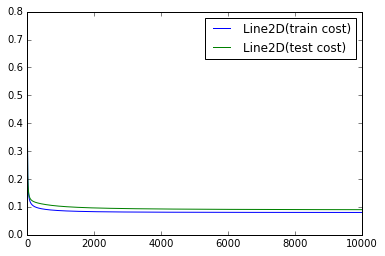

In [6]:
legend1, = plt.plot(train_costs, label='train cost')
legend2, = plt.plot(test_costs, label='test cost')
plt.legend([legend1, legend2])
plt.plot()

In [26]:
# Now we're going to redo this for a neural net
import numpy as np
import matplotlib.pyplot as plt

from sklearn.utils import shuffle

def y2indicator(y, K):
    N = len(y)
    ind = np.zeros((N, K))
    for i in range(N):
        ind[i, y[i]] = 1
    return ind

X, Y = get_data()
X, Y = shuffle(X, Y)
Y = Y.astype(np.int32)
M = 5 # Number of hidden nodes
D = X.shape[1]
K = len(set(Y))

# split data into train or test sets
Xtrain = X[:-100]
Ytrain = Y[:-100]
Ytrain_ind = y2indicator(Ytrain, K)
Xtest = X[-100:]
Ytest = Y[-100:]
Ytest_ind = y2indicator(Ytest, K)

# Randomly initialize our weights
W1 = np.random.randn(D, M)
b1 = np.zeros(M)
W2 = np.random.randn(M, K)
b2 = np.zeros(K)

def softmax(a):
    expA = np.exp(a)
    return expA / expA.sum(axis=1, keepdims=True)

def forward(X, W1, b1, W2, b2):
    # Calculate the values of the hidden nodes z
    # Then return softmax of those values times the weights W2
    Z = np.tanh(X.dot(W1) + b1)
    return softmax(Z.dot(W2) + b2), Z

def predict(P_Y_given_X):
    # Returns vector for predictions of each row
    return np.argmax(P_Y_given_X, axis=1)

def classification_rate(Y, P):
    # Compare the one-hot encoded matrices of actual vs. predicted classes
    return np.mean(Y == P)

def cross_entroy(T, pY):
    # take the average of the product of one-hot encoded targets matrix
    # and the log of the corresponding prediction values
    return -np.mean(T * np.log(pY))

# Now we're ready to enter our main train loop
train_costs = []
test_costs = []
learning_rate = 0.001
for i in range(10000):
    pYtrain, Ztrain = forward(Xtrain, W1, b1, W2, b2)
    pYtest, Ztest = forward(Xtest, W1, b1, W2, b2)
    
    ctrain = cross_entropy(Ytrain_ind, pYtrain)
    ctest = cross_entropy(Ytest_ind, pYtest)
    train_costs.append(ctrain)
    test_costs.append(ctest)
    
    # now do some gradient descent
    W2 -= learning_rate*Ztrain.T.dot(pYtrain - Ytrain_ind)
    b2 -= learning_rate*(pYtrain - Ytrain_ind).sum()
    dZ = (pYtrain - Ytrain_ind).dot(W2.T) * (1 - Ztrain*Ztrain) # second term is derivative of tanh
    W1 -= learning_rate * Xtrain.T.dot(dZ)
    b1 -= learning_rate*dZ.sum(axis=0)
    if i % 1000 == 0:
        print(i, ctrain, ctest)
    
print("Final train classification_rate:", classification_rate(Ytrain, predict(pYtrain)))
print("Final test classification_rate:", classification_rate(Ytest, predict(pYtest)))
# Should do better than the logistic regression case

0 0.526306378623 0.552011339618
1000 0.0372129366366 0.0593518595036
2000 0.0209929080701 0.0413376624014
3000 0.0156544864222 0.0428671107294
4000 0.0130564061158 0.043899106304
5000 0.0114048424543 0.0447225757902
6000 0.0102486488882 0.0452588481523
7000 0.0093892080223 0.0457753054859
8000 0.00871639326345 0.0462500125637
9000 0.00817104906567 0.046673214252
Final train classification_rate: 0.99
Final test classification_rate: 0.95


[]

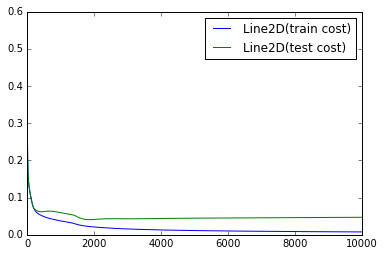

In [27]:
legend1, = plt.plot(train_costs, label='train cost')
legend2, = plt.plot(test_costs, label='test cost')
plt.legend([legend1, legend2])
plt.plot()